In [ ]:
#https://gist.github.com/ezzeldinadel/dfd0b1aba2736f9193a206c0445bc332#file-insider-threat-ipynb
#https://www.analyticsvidhya.com/blog/2020/10/overcoming-class-imbalance-using-smote-techniques/#:~:text=Smote%20should%20be%20used%20when,difference%20between%20smote%20and%20oversampling%3F

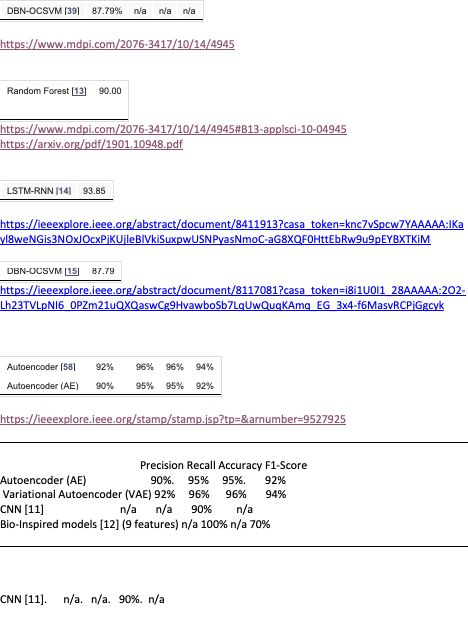

# Mounting Data Source

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
path_to_dataset = "/content/drive/MyDrive/DACS_Project/r4.2/"
log_types = ["device", "email", "file", "logon"] #http to be added
log_fields_list = [
    ["date", "user", "activity"],
    ["date", "user", "to", "cc", "bcc"],
    ["date", "user", "filename"],
    ["date", "user", "activity"],
    ["date", "user", "url"],
]
features = 0
feature_map = {}

def add_feature(name):
    """Add a feature to a dictionary to be encoded."""
    if name not in feature_map:
        global features
        feature_map[name] = features
        features += 1

# Feature Extraction


In [ ]:
add_feature("Weekday_Logon_Normal")
add_feature("Weekday_Logon_After")
add_feature("Weekend_Logon")
add_feature("Logoff")

add_feature("Connect_Normal")
add_feature("Connect_After")
add_feature("Connect_Weekend")
add_feature("Disconnect")

add_feature("Email_In")
add_feature("Email_Out")

add_feature("File_exe")
add_feature("File_jpg")
add_feature("File_zip")
add_feature("File_txt")
add_feature("File_doc")
add_feature("File_pdf")
add_feature("File_other")

add_feature("url")

def file_features(row):
    """Creates a feature recording the file extension of the file used."""
    if row["filename"].endswith(".exe"):
        return feature_map["File_exe"]
    if row["filename"].endswith(".jpg"):
        return feature_map["File_jpg"]
    if row["filename"].endswith(".zip"):
        return feature_map["File_zip"]
    if row["filename"].endswith(".txt"):
        return feature_map["File_txt"]
    if row["filename"].endswith(".doc"):
        return feature_map["File_doc"]
    if row["filename"].endswith(".pdf"):
        return feature_map["File_pdf"]
    else:
        return feature_map["File_other"]


def email_features(row):
    """Creates a feature recording whether an email has been sent externally."""
    outsider = False
    if not pd.isnull(row["to"]):
        for address in row["to"].split(";"):
            if not address.endswith("dtaa.com"):
                outsider = True

    if not pd.isnull(row["cc"]):
        for address in row["cc"].split(";"):
            if not address.endswith("dtaa.com"):
                outsider = True

    if not pd.isnull(row["bcc"]):
        for address in row["bcc"].split(";"):
            if not address.endswith("dtaa.com"):
                outsider = True
    if outsider:
        return feature_map["Email_Out"]
    else:
        return feature_map["Email_In"]


def device_features(row):
    """Creates a feature for whether the user has connected during normal hours or otherwise."""
    if row["activity"] == "Connect":
        if row["date"].weekday() < 5:
            if row["date"].hour >= 8 and row["date"].hour < 17:
                return feature_map["Connect_Normal"]
            else:
                return feature_map["Connect_After"]
        else:
            return feature_map["Connect_Weekend"]
    else:
        return feature_map["Disconnect"]



def logon_features(row):
    """Creates a feature for whether the user logged in during normal hours or otherwise."""
    if row["activity"] == "Logon":
        if row["date"].weekday() < 5:
            if row["date"].hour >= 8 and row["date"].hour < 17:
                return feature_map["Weekday_Logon_Normal"]
            else:
                return feature_map["Weekday_Logon_After"]
        else:
            return feature_map["Weekend_Logon"]
    else:
        return feature_map["Logoff"]


def http_features(row):
    """Encodes the URL visited."""
    return feature_map["url"]


def date_to_day(row):
    """Converts a full datetime to date only."""
    day_only = row["date"].date()
    return day_only

log_feature_functions = [
    device_features,
    email_features,
    file_features,
    logon_features,
    http_features,
]

In [ ]:
feature_map

{'Weekday_Logon_Normal': 0,
 'Weekday_Logon_After': 1,
 'Weekend_Logon': 2,
 'Logoff': 3,
 'Connect_Normal': 4,
 'Connect_After': 5,
 'Connect_Weekend': 6,
 'Disconnect': 7,
 'Email_In': 8,
 'Email_Out': 9,
 'File_exe': 10,
 'File_jpg': 11,
 'File_zip': 12,
 'File_txt': 13,
 'File_doc': 14,
 'File_pdf': 15,
 'File_other': 16,
 'url': 17}

In [ ]:
dfs = []
for i in range(len(log_types)):
    log_type = log_types[i]
    print("logtype",log_type)
    log_fields = log_fields_list[i]
    log_feature_function = log_feature_functions[i]
    print("log_feature_function", log_feature_function)
    df = pd.read_csv(
        path_to_dataset + log_type + ".csv", usecols=log_fields, index_col=None
    )
    date_format = "%m/%d/%Y %H:%M:%S"
    df["date"] = pd.to_datetime(df["date"], format=date_format)

    new_feature = df.apply(log_feature_function, axis=1)
    df["feature"] = new_feature

    cols_to_keep = ["date", "user", "feature"]
    df = df[cols_to_keep]

    df["date"] = df.apply(date_to_day, axis=1)
    # if (df["feature"] == 4).any():
    #   print("df when feature==4:")
    #   print(df[df["feature"] == 4])
    dfs.append(df)

logtype device
log_feature_function <function device_features at 0x7d972e703a30>
logtype email
log_feature_function <function email_features at 0x7d972e7039a0>
logtype file
log_feature_function <function file_features at 0x7d972e703910>
logtype logon
log_feature_function <function logon_features at 0x7d972e703ac0>


# generating threat users list

In [ ]:
# Group by 'user' and aggregate the features
grouped_df = joint.groupby('user')['feature'].agg(list).reset_index()

grouped_df.head()

,user,feature
0,AAE0190,"[9, 3, 0, 8, 8, 8, 8, 8, 8, 9, 8, 8, 8, 8, 8, ..."
1,AAF0535,"[9, 8, 8, 0, 3, 8, 14, 8, 9, 0, 3, 4, 7, 4, 7,..."
2,AAF0791,"[9, 8, 9, 9, 9, 9, 9, 8, 9, 3, 0, 9, 9, 9, 8, ..."
3,AAL0706,"[8, 3, 1, 9, 1, 3, 1, 3, 8, 9, 1, 3, 9, 1, 3, ..."
4,AAM0658,"[8, 9, 8, 3, 0, 8, 8, 8, 0, 3, 3, 0, 8, 9, 9, ..."


In [ ]:
import pandas as pd
from collections import Counter



result_dict = {'user': [], 'feature_list': []}

for index, row in grouped_df.iterrows():
    user_id = row['user']
    user_features = row['feature']

    feature_counts = dict(Counter(user_features))

    result_dict['user'].append(user_id)
    result_dict['feature_list'].append(feature_counts)

# Display the result_dict
print(result_dict)


{'user': ['AAE0190', 'AAF0535', 'AAF0791', 'AAL0706', 'AAM0658', 'AAN0823', 'AAS0442', 'AAV0450', 'AAW0353', 'ABC0174', 'ABC0253', 'ABH0663', 'ABM0845', 'ABN0239', 'ACC0042', 'ACV0812', 'ADC0391', 'ADD0846', 'ADF0397', 'AES0827', 'AGB0186', 'AGB0643', 'AHC0142', 'AHD0848', 'AHG0634', 'AHM0410', 'AIB0948', 'AIH0675', 'AIM0627', 'AIP0394', 'AIP0982', 'AIS0405', 'AJC0840', 'AJD0074', 'AJF0370', 'AJH0175', 'AJL0462', 'AJN0607', 'AJP0723', 'AJR0319', 'AJR0932', 'AKC0924', 'AKF0709', 'AKH0758', 'AKK0329', 'AKR0057', 'AKW0167', 'ALB0892', 'ALC0788', 'ALD0529', 'ALD0544', 'ALH0402', 'AMD0077', 'AMH0464', 'AMH0794', 'AMJ0297', 'AMM0014', 'AMR0318', 'AMR0400', 'AMV0036', 'AMW0392', 'ANM0123', 'ANP0555', 'ANT0430', 'AOB0019', 'AOK0844', 'AOS0987', 'APG0307', 'AQD0820', 'ARA0252', 'ARB0834', 'ARB0881', 'ARD0509', 'ARL0034', 'ASB0796', 'ASD0577', 'ASG0048', 'ASG0692', 'ASL0378', 'ASM0575', 'ASS0206', 'ASS0517', 'ASV0946', 'ATE0869', 'ATF0274', 'ATP0662', 'AVM0947', 'AWM0764', 'BAH0875', 'BAJ0654', 

Non malicious Features

In [ ]:
non_malicious_list=[0,3,4,8,16]

In [ ]:
# Create a DataFrame
data_df = pd.DataFrame.from_dict(result_dict)

# Calculate the sum of keys [0,3,4,8,16] and other keys for each feature
data_df['Non_Malicious'] = data_df['feature_list'].apply(lambda x: sum(x.get(key, 0) for key in [0, 3, 4, 8, 16]))
data_df['Malicious'] = data_df['feature_list'].apply(lambda x: sum(x.get(key, 0) for key in x.keys() if key not in [0, 3, 4, 8, 16]))

data_df['target'] = data_df.apply(lambda row: 1 if row['Malicious'] > row['Non_Malicious'] else 0, axis=1)

print(data_df)

        user                                       feature_list  \
0    AAE0190                 {9: 2237, 3: 346, 0: 346, 8: 2474}   
1    AAF0535  {9: 191, 8: 289, 0: 164, 3: 164, 14: 228, 4: 3...   
2    AAF0791                 {9: 1847, 8: 1165, 3: 346, 0: 346}   
3    AAL0706                   {8: 147, 3: 346, 1: 346, 9: 189}   
4    AAM0658  {8: 328, 9: 331, 3: 229, 0: 224, 7: 6, 5: 6, 1...   
..       ...                                                ...   
995  ZKS0899  {9: 573, 12: 395, 14: 5508, 3: 385, 15: 1704, ...   
996  ZMC0284                 {9: 1093, 8: 1904, 3: 346, 0: 346}   
997  ZSB0649                   {9: 421, 3: 346, 0: 346, 8: 596}   
998  ZSK0258                 {8: 1510, 9: 1490, 1: 346, 3: 346}   
999  ZSL0305                   {9: 194, 3: 346, 0: 346, 8: 143}   

     Non_Malicious  Malicious  target  
0             3166       2237       0  
1              963        890       0  
2             1857       1847       0  
3              493        535      

In [ ]:
data_df['target'].value_counts()

0    719
1    281
Name: target, dtype: int64

In [ ]:
threat_actors=list(data_df['user'][data_df['target']==1])

X, Y data set

In [ ]:
start_date = joint["date"].iloc[0]
end_date = joint["date"].iloc[-1]
time_horizon = (end_date - start_date).days + 1

def vectorize_dataset(df):
    """Takes the dataset and featurizes it."""
    users = set(df["user"].values)
    X = np.zeros((len(users), len(feature_map), time_horizon))
    y = np.zeros((len(users)))
    for index, user in enumerate(users):
        x = vectorize_user_time_series(user, df)
        if x.shape[1] > time_horizon:
            x = x[:, :time_horizon]  # Trim x if it's longer than time_horizon
        X[index, :, :x.shape[1]] = x
        y[index] = int(user in threat_actors)

    return X, y


def date_to_index(date):
    """Indexes dates by counting the number of days since the starting date of the dataset."""
    return (date - start_date).days

def extract_time_series_by_user(user_name, df):
    """Filters the dataframe down to a specific user."""
    return df[df["user"] == user_name]


def vectorize_user_time_series(user_name, df):
    user_time_series = extract_time_series_by_user(user_name, df)
    x = np.zeros((len(feature_map), time_horizon))
    event_date_indices = user_time_series["date"].apply(date_to_index).to_numpy()
    event_features = user_time_series["feature"].to_numpy()

    for i in range(len(event_date_indices)):
        if event_features[i] < len(feature_map):  # Check if the feature index is within bounds
            x[event_features[i], event_date_indices[i]] += 1

    return x

X, y = vectorize_dataset(joint)

Splitting Train and Test data set

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [ ]:
X_train_reshaped = X_train.reshape(
    [X_train.shape[0], X_train.shape[1] * X_train.shape[2]]
)
X_test_reshaped = X_test.reshape([X_test.shape[0], X_test.shape[1] * X_test.shape[2]])
# X_train_normal = X_train_reshaped[y_train == 0, :]
# print(X_train_normal.shape)
# X_train_threat = X_train_reshaped[y_train == 1, :]
# print(X_train_threat.shape)
# X_test_normal = X_test_reshaped[y_test == 0, :]
# print(X_test_normal.shape)
# X_test_threat = X_test_reshaped[y_test == 1, :]
# print(X_test_threat.shape)

In [ ]:
X_train_reshaped.shape

(750, 9018)

#  overSampling Techniques

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import TomekLinks
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import EditedNearestNeighbours

### SMOTE

In [ ]:
# smote analysis
# transform the dataset
# oversample = SMOTE()
# X_train_reshaped, y_train = oversample.fit_resample(X_train_reshaped, y_train)

ADASYN

In [ ]:
# #ADASYN
# adasyn = ADASYN(sampling_strategy="auto", random_state=42)
# X_train_reshaped, y_train = adasyn.fit_resample(X_train_reshaped, y_train)


###  SMOTE + TomekLinks

In [ ]:

# Create a pipeline with SMOTE followed by TomekLinks
# pipeline = Pipeline([
#     ('smote', SMOTE(sampling_strategy='auto', random_state=42)),
#     ('tomek', TomekLinks(sampling_strategy='auto')),
# ])

# # Apply SMOTE and TomekLinks
# X_train_reshaped, y_train = pipeline.fit_resample(X_train_reshaped, y_train)

### SMOTE + ENN

In [ ]:


# # Create a pipeline with SMOTE followed by ENN
pipeline = Pipeline([
    ('smote', SMOTE(sampling_strategy='auto', random_state=42)),
    ('enn', EditedNearestNeighbours(sampling_strategy='auto')),
])
X_train_reshaped, y_train = pipeline.fit_resample(X_train_reshaped, y_train)

In [ ]:
X_train_reshaped.shape ,y_train.shape

((1065, 9018), (1065,))

## MODELS

Logistic Regression

In [ ]:
#All methods
# import the class
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


# instantiate the model (using the default parameters)
logreg = LogisticRegression(random_state=16)

# fit the model with data
logreg.fit(X_train_reshaped, y_train)

y_pred = logreg.predict(X_test_reshaped)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

Accuracy: 0.928
              precision    recall  f1-score   support

         0.0       0.94      0.97      0.95       180
         1.0       0.91      0.83      0.87        70

    accuracy                           0.93       250
   macro avg       0.92      0.90      0.91       250
weighted avg       0.93      0.93      0.93       250



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# coefficients = logreg.coef_[0]
# feature_importance = abs(coefficients)
# feature_importance


# # [i for i in logreg.coef_[0] if i > 0]
# ind=[]
# for i in range(len(logreg.coef_[0])):
#   if logreg.coef_[0][i] > 0:
#     ind.append(i)



Random Forest Classifier

In [ ]:
#SMOTE ENN
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

rf = RandomForestClassifier(n_estimators=100)

rf.fit(X_train_reshaped, y_train)

y_pred = rf.predict(X_test_reshaped)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

Accuracy: 0.872
              precision    recall  f1-score   support

         0.0       0.89      0.94      0.91       180
         1.0       0.82      0.70      0.75        70

    accuracy                           0.87       250
   macro avg       0.85      0.82      0.83       250
weighted avg       0.87      0.87      0.87       250



SVC

In [ ]:
#SMOTE, ADASYN,TomekLinks

from sklearn.svm import SVC
from sklearn.metrics import classification_report

# SVM model
svm = SVC()
svm.fit(X_train_reshaped, y_train)

# Predictions on test data
y_pred = svm.predict(X_test_reshaped)

# Accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"SVM Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

SVM Accuracy: 0.932
              precision    recall  f1-score   support

         0.0       0.93      0.98      0.95       180
         1.0       0.95      0.80      0.87        70

    accuracy                           0.93       250
   macro avg       0.94      0.89      0.91       250
weighted avg       0.93      0.93      0.93       250



### AdaBoostClassifier

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

# Create a weak learner (in this case, a decision tree)
base_classifier = DecisionTreeClassifier(max_depth=1)

# Create an AdaBoost classifier using the weak learner
adaboost_classifier = AdaBoostClassifier(base_classifier, n_estimators=50, random_state=42)

# Train the Adaboost classifier
adaboost_classifier.fit(X_train_reshaped, y_train)

# Make predictions on the test set
predictions = adaboost_classifier.predict(X_test_reshaped)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)


print(f"Accuracy: {accuracy}")
print(classification_report(y_test, predictions))



Accuracy: 0.852
              precision    recall  f1-score   support

         0.0       0.88      0.92      0.90       180
         1.0       0.77      0.67      0.72        70

    accuracy                           0.85       250
   macro avg       0.82      0.80      0.81       250
weighted avg       0.85      0.85      0.85       250



### Decision Tree

In [ ]:


from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
# Create a Decision Tree classifier
clf = DecisionTreeClassifier(random_state=47)

# Train the classifier on the training data
clf.fit(X_train_reshaped, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test_reshaped)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

Accuracy: 0.776
              precision    recall  f1-score   support

         0.0       0.86      0.83      0.84       180
         1.0       0.59      0.64      0.62        70

    accuracy                           0.78       250
   macro avg       0.72      0.74      0.73       250
weighted avg       0.78      0.78      0.78       250



### IsolationForest

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Create an Isolation Forest model
isolation_forest = IsolationForest(n_estimators=100, contamination=0.2, random_state=40)

# Fit the model on the training data
isolation_forest.fit(X_train_reshaped)

# Predict outliers/anomalies on the test set
y_pred = isolation_forest.predict(X_test_reshaped)

# Convert predictions (-1: anomaly, 1: normal) to binary labels (0: normal, 1: anomaly)
y_pred_binary = [1 if pred == -1 else 0 for pred in y_pred]

# Evaluate the Isolation Forest model
print("Classification Report:")
print(classification_report(y_test, y_pred_binary))


# Evaluate the Isolation Forest model
print("Accuracy")
print(accuracy_score(y_test, y_pred_binary))




Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.95      0.88       180
         1.0       0.78      0.46      0.58        70

    accuracy                           0.81       250
   macro avg       0.80      0.70      0.73       250
weighted avg       0.81      0.81      0.79       250

Accuracy
0.812


### CNN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

# Define the input shape based on your data
input_shape = (9018, 1)  # Assuming each row has 9018 features

# Reshape your data to fit the CNN input shape
X_train_reshaped_cnn = X_train_reshaped.reshape((-1, 9018, 1))  # Assuming X_train contains your training features

# Create the CNN model
model = Sequential()

# Add convolutional layers
model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# Flatten the output for Dense layers
model.add(Flatten())

# Add Dense layers for classification
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))  # 2 output classes

# Compile the model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

# Train the model
model.fit(X_train_reshaped_cnn, y_train, epochs=19, batch_size=32, validation_split=0.2)


from sklearn.metrics import classification_report
import numpy as np

# Reshape the test data if required
X_test_reshaped_cnn = X_test_reshaped.reshape((-1, 9018, 1))  # Adjust the shape based on your test data

# Make predictions
predictions = model.predict(X_test_reshaped_cnn)

# Convert predictions from one-hot encoding to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Calculate precision, recall, and F1 score
report = classification_report(y_test, predicted_classes)
accuracy = accuracy_score(y_test, predicted_classes)
print(accuracy)
print("Classification Report:\n", report)


Epoch 1/19
27/27 [==============================] - 12s 39ms/step - loss: 1.3072 - accuracy: 0.7723 - val_loss: 0.5415 - val_accuracy: 0.6291
Epoch 2/19
27/27 [==============================] - 1s 24ms/step - loss: 0.2116 - accuracy: 0.9096 - val_loss: 0.1056 - val_accuracy: 0.9906
Epoch 3/19
27/27 [==============================] - 1s 24ms/step - loss: 0.0873 - accuracy: 0.9789 - val_loss: 0.0636 - val_accuracy: 0.9906
Epoch 4/19
27/27 [==============================] - 1s 24ms/step - loss: 0.0392 - accuracy: 0.9906 - val_loss: 0.0167 - val_accuracy: 0.9953
Epoch 5/19
27/27 [==============================] - 1s 24ms/step - loss: 0.0248 - accuracy: 0.9965 - val_loss: 0.0333 - val_accuracy: 0.9906
Epoch 6/19
27/27 [==============================] - 1s 23ms/step - loss: 0.0131 - accuracy: 1.0000 - val_loss: 0.0882 - val_accuracy: 0.9765
Epoch 7/19
27/27 [==============================] - 1s 24ms/step - loss: 0.0266 - accuracy: 0.9906 - val_loss: 0.0302 - val_accuracy: 0.9906
Epoch 8/19
2

In [ ]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, Dropout
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping

# Assuming X_train contains your training features and y_train contains corresponding labels

# model = Sequential()

# # Add LSTM layer
# model.add(LSTM(units=128, input_shape=(9018, 1), return_sequences=True))
# model.add(Dropout(0.3))  # Adjust dropout rate for regularization

# model.add(LSTM(units=64))  # Add another LSTM layer
# model.add(Dropout(0.3))  # Dropout for regularization

# # Dense layers for classification
# model.add(Dense(32, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))  # Sigmoid for binary classification

# # Compile the model
# model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# # Early stopping to prevent overfitting
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# # Train the model
# history = model.fit(X_train_reshaped, y_train, epochs=50, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

# X_test_reshaped = X_test_reshaped.reshape((X_test_reshaped.shape[0], 9018, 1))

# y_pred = model.predict(X_test_reshaped)

# y_pred_binary = (y_pred > 0.5).astype(int).flatten()


# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


# accuracy = accuracy_score(y_test, y_pred_binary)
# print(f"Accuracy: {accuracy:.4f}")

# precision = precision_score(y_test, y_pred_binary)
# recall = recall_score(y_test, y_pred_binary)
# f1 = f1_score(y_test, y_pred_binary)

# print(f"Precision: {precision:.4f}")
# print(f"Recall: {recall:.4f}")
# print(f"F1-Score: {f1:.4f}")


# conf_matrix = confusion_matrix(y_test, y_pred_binary)
# print("Confusion Matrix:")
# print(conf_matrix)


In [ ]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dropout, SimpleRNN, Dense
# from tensorflow.keras.optimizers import Adam

# model = Sequential()

# model.add(SimpleRNN(units=128, activation='tanh', input_shape=(9018, 1), return_sequences=True))
# model.add(Dropout(0.3))  # Adjust dropout rate

# model.add(SimpleRNN(units=64, activation='tanh'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(2, activation='softmax'))

# model.compile(loss='sparse_categorical_crossentropy',
#               optimizer=Adam(learning_rate=0.0001),  # Change lr to learning_rate
#               metrics=['accuracy'])

# model.fit(X_train_reshaped, y_train, epochs=15, batch_size=64, validation_split=0.2)


In [ ]:
# from sklearn.ensemble import IsolationForest

# contamination_parameter = 0.035
# IF = IsolationForest(n_estimators=100, max_samples=256, contamination=contamination_parameter)

# IF.fit(X_train_reshaped)
# normal_scores = IF.decision_function(X_train_normal)

# import matplotlib.mlab as mlab
# import matplotlib.pyplot as plt

# fig = plt.figure(figsize=(8, 4), dpi=600, facecolor="w", edgecolor="k")

# normal = plt.hist(normal_scores, 50, density=True)

# #plt.xlim((-0.2, 0.2))
# plt.xlabel("Anomaly score")
# plt.ylabel("Percentage")
# plt.title("Distribution of anomaly score for non threats")

# y_pred_normal=IF.predict(X_test_normal)
# 100*list(y_pred_normal).count(1)/len(list(y_pred_normal))

# anomaly_scores = IF.decision_function(X_train_threat)

# fig = plt.figure(figsize=(8, 4), dpi=600, facecolor="w", edgecolor="k")

# anomaly = plt.hist(anomaly_scores, 50, density=True)

# plt.xlim((-0.2, 0.2))
# plt.xlabel("Anomaly score")
# plt.ylabel("Percentage")
# plt.title("Distribution of anomaly score for threats")

# y_pred_threat=IF.predict(X_test_threat)
# 100*list(y_pred_threat).count(-1)/len(list(X_test_threat))


In [ ]:
import pandas as pd

# Define the features and their descriptions
features_data = {
    "Feature": [
        "Weekday_Logon_Normal", "Weekday_Logon_After", "Weekend_Logon", "Logoff",
        "Connect_Normal", "Connect_After", "Connect_Weekend", "Disconnect",
        "Email_In", "Email_Out",
        "File_exe", "File_jpg", "File_zip", "File_txt", "File_doc", "File_pdf", "File_other"
    ],
    "Description": [
        "Indicates the user's logon during normal weekday hours (Monday to Friday, 8 AM to 5 PM).",
        "Indicates the user's logon after normal weekday hours.",
        "Indicates the user's logon during the weekend.",
        "Represents the user's logoff activity.",
        "Reflects the user's device connection during normal weekday hours.",
        "Indicates the user's device connection after normal weekday hours.",
        "Indicates the user's device connection during the weekend.",
        "Represents the user's device disconnection activity.",
        "Indicates internal emails sent within the organization.",
        "Marks emails sent externally, outside the organization.",
        "Records the use of executable files.",
        "Indicates the use of JPG image files.",
        "Represents the use of ZIP archive files.",
        "Indicates the use of text files.",
        "Represents the use of Word document files.",
        "Indicates the use of PDF files.",
        "Captures file types not falling into the specified categories (e.g., files with extensions other than .exe, .jpg, .zip, .txt, .doc, .pdf)."
    ]
}

# Create a DataFrame from the dictionary
features_df = pd.DataFrame(features_data)

# Display the DataFrame
print(features_df)


                 Feature                                        Description
0   Weekday_Logon_Normal  Indicates the user's logon during normal weekd...
1    Weekday_Logon_After  Indicates the user's logon after normal weekda...
2          Weekend_Logon     Indicates the user's logon during the weekend.
3                 Logoff             Represents the user's logoff activity.
4         Connect_Normal  Reflects the user's device connection during n...
5          Connect_After  Indicates the user's device connection after n...
6        Connect_Weekend  Indicates the user's device connection during ...
7             Disconnect  Represents the user's device disconnection act...
8               Email_In  Indicates internal emails sent within the orga...
9              Email_Out  Marks emails sent externally, outside the orga...
10              File_exe               Records the use of executable files.
11              File_jpg              Indicates the use of JPG image files.
12          

In [ ]:
features_df

,Feature,Description
0,Weekday_Logon_Normal,Indicates the user's logon during normal weekd...
1,Weekday_Logon_After,Indicates the user's logon after normal weekda...
2,Weekend_Logon,Indicates the user's logon during the weekend.
3,Logoff,Represents the user's logoff activity.
4,Connect_Normal,Reflects the user's device connection during n...
5,Connect_After,Indicates the user's device connection after n...
6,Connect_Weekend,Indicates the user's device connection during ...
7,Disconnect,Represents the user's device disconnection act...
8,Email_In,Indicates internal emails sent within the orga...
9,Email_Out,"Marks emails sent externally, outside the orga..."
